<a href="https://colab.research.google.com/github/dheerajbaiju501/3D_semantic_segmentation/blob/main/3d_sematic_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import tifffile as tiff
import cv2
import numpy as np
import numpy as np
from sklearn.model_selection import train_test_split
import shutil as sh
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2DTranspose,ZeroPadding2D,Conv2D,Add,Dropout,Input,UpSampling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import load_img,img_to_array,plot_model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint,EarlyStopping,Callback

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataset_path = '/content/drive/MyDrive/volumedata.tif'
data = tiff.imread(dataset_path)

In [4]:
if not os.path.isdir("electron-microscopy-3d-segmentation/data/images"):
      os.makedirs("electron-microscopy-3d-segmentation/data/images")
if not os.path.isdir("electron-microscopy-3d-segmentation/data/masks"):
      os.makedirs("electron-microscopy-3d-segmentation/data/masks")

In [5]:
Train_images=tiff.imread("/content/drive/MyDrive/training.tif")
Train_masks=tiff.imread("/content/drive/MyDrive/training_groundtruth.tif")
Train_images.shape
Train_masks.shape

(165, 768, 1024)

In [6]:
for img in range(Train_images.shape[0]):
    img_name = "image_{}.jpg".format(img)
    cv2.imwrite("electron-microscopy-3d-segmentation/data/images/{}".format(img_name), Train_images[img])
    mask_name = "mask_{}_L.jpg".format(img)
    cv2.imwrite("electron-microscopy-3d-segmentation/data/masks/{}".format(mask_name), Train_masks[img])

In [7]:
if not os.path.isdir("data/images"):
    os.makedirs("data/images")
if not os.path.isdir("data/masks"):
    os.makedirs("data/masks")
for img in range(Train_images.shape[0]):
    img_name = "image_{}.jpg".format(img)
    cv2.imwrite("data/images/{}".format(img_name), Train_images[img])
    mask_name = "mask_{}_L.jpg".format(img)
    cv2.imwrite("data/masks/{}".format(mask_name), Train_masks[img])

In [8]:
images=os.listdir(r"data/images")
masks=os.listdir(r"data/masks")
Train_images,Val_images,Train_masks,Val_masks=train_test_split(images,masks,test_size=.2,shuffle=True)

In [9]:
print(Train_images[:3])
print(Train_masks[:3])

['image_128.jpg', 'image_63.jpg', 'image_88.jpg']
['mask_15_L.jpg', 'mask_38_L.jpg', 'mask_140_L.jpg']


In [10]:
for name in images :
  if name in Train_images:
    path2save="Train"
  if name in Val_images:
    path2save="Val"
  if not os.path.isdir(r"{}/images".format(path2save)):
      os.makedirs(r"{}/images".format(path2save))
  sh.move(r"data/images/{}".format(name),r"{}/images/{}".format(path2save,name))

In [11]:
for name in masks :
  if name in Train_masks:
    path2save="Train"
  if name in Val_masks:
    path2save="Val"
  if not os.path.isdir(r"{}/masks".format(path2save)):
      os.makedirs(r"{}/masks".format(path2save))
  sh.move(r"data/masks/{}".format(name),r"{}/masks/{}".format(path2save,name))

In [12]:
if os.path.exists("electron-microscopy-3d-segmentation/data"):
    sh.rmtree("electron-microscopy-3d-segmentation/data")

In [13]:
def Load_image(path,Size):
    img = cv2.imread(path)
    img=cv2.resize(img,(Size,Size))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img=img/255.
    return img

In [14]:
def show_image(image, title=None):
    plt.imshow(image,cmap='gray')
    plt.title(title)
    plt.axis('off')

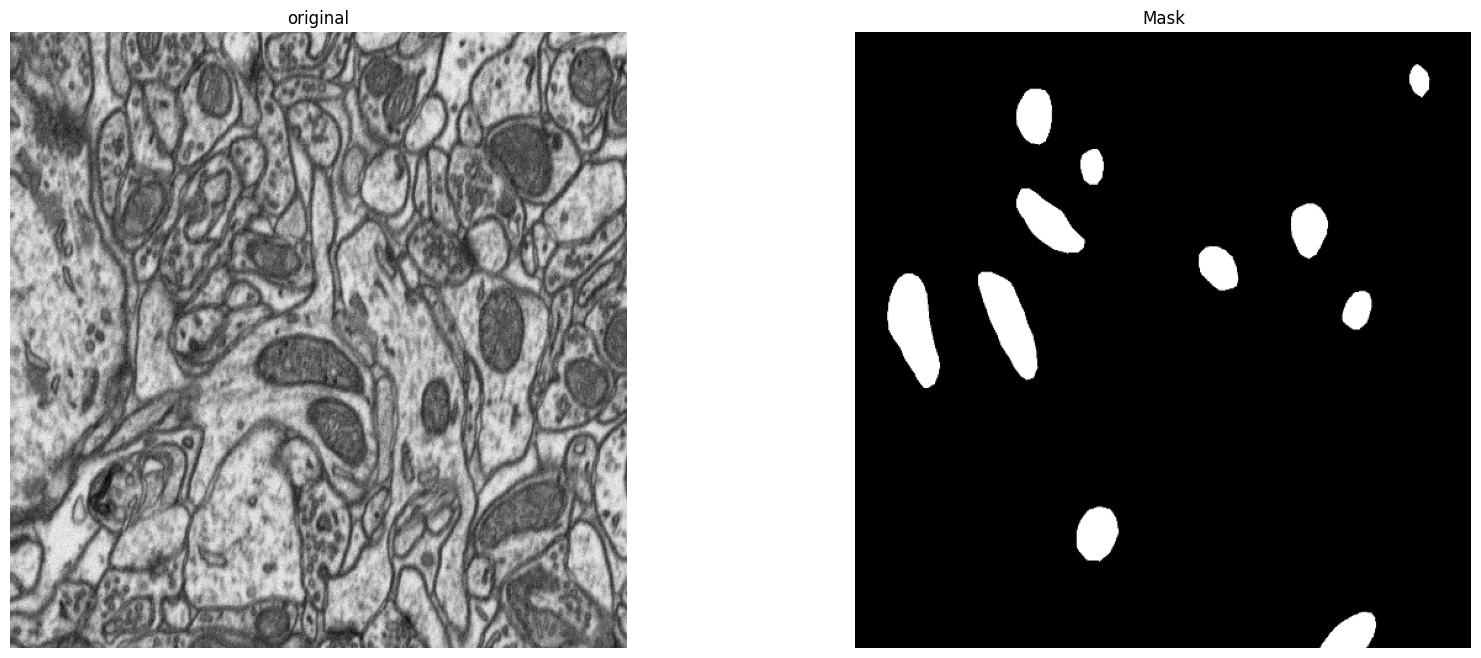

In [15]:
Size=500

img=os.listdir(r"Train/images")
mask=os.listdir(r"Train/masks")
image=Load_image(r"Train/images/{}".format(img[0]),Size)
label=Load_image(r"Train/masks/{}".format(mask[0]),Size)

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
show_image(image,"original")
plt.subplot(1,2,2)
show_image(label,"Mask")

In [16]:
def decoder_block(input,skip_features, num_filters,conv_padding=False,zero_pad=False):

    x= Conv2DTranspose(num_filters, 2, activation = 'relu',strides=(2,2), kernel_initializer = 'he_normal')(input)

    if zero_pad == True:
      x=ZeroPadding2D((1,1))(x)

    if conv_padding ==True:
        x=Conv2D(num_filters, 3, activation = 'relu', padding='same', kernel_initializer = 'he_normal')(x)
    else:
        x=Conv2D(num_filters, 2, activation = 'relu', kernel_initializer = 'he_normal')(x)

    x = Add()([x, skip_features])
    return x

In [17]:
def Unet_VGG19(input_size,n_classes):
    inp = Input(input_size)

    vgg19 = VGG19(include_top=False, weights="imagenet", input_tensor=inp)

    E0=vgg19.get_layer("block1_conv2").output
    E0=Conv2D(128, 3, activation = 'relu', padding='same')(E0)
    E0=Conv2D(64, 3, activation = 'relu', padding='same')(E0)

    E1=vgg19.get_layer("block1_pool").output
    E1=Conv2D(128, 3, activation = 'relu', padding='same')(E1)
    E1=Conv2D(64, 3, activation = 'relu', padding='same')(E1)

    E2=vgg19.get_layer("block2_pool").output
    E2=Conv2D(128, 3, activation = 'relu', padding='same')(E2)

    E3=vgg19.get_layer("block3_pool").output
    E3=Conv2D(512, 3, activation = 'relu', padding='same')(E3)
    E3=Conv2D(256, 3, activation = 'relu', padding='same')(E3)

    E4=vgg19.get_layer("block4_pool").output
    E4=Conv2D(1024, 3, activation = 'relu', padding='same')(E4)
    E4=Conv2D(512, 3, activation = 'relu', padding='same')(E4)

    B1=vgg19.get_layer("block5_pool").output
    B1=Conv2D(1024, 3, activation = 'relu', padding='same')(B1)

    D1=decoder_block(B1,E4,512,zero_pad=True)
    D2=decoder_block(D1,E3,256,conv_padding=True)
    D3=decoder_block(D2,E2,128,zero_pad=True)
    D4=decoder_block(D3,E1,64,conv_padding=True)
    D5=decoder_block(D4,E0,64,conv_padding=True)

    outputs=Conv2D(n_classes, 1, activation = 'sigmoid', padding = 'same')(D5)
    model = Model(inp,outputs, name="VGG19_U-Net")
    model.compile(optimizer = Adam(learning_rate = 1e-4), loss ='binary_crossentropy', metrics = ['accuracy' , tf.keras.metrics.BinaryIoU(target_class_ids=[0, 1],threshold=0.6,name="IOU")])
    model.summary()
    return model

In [18]:
!pip install h5py

In [19]:
model=Unet_VGG19(input_size=(500,500,3),n_classes=1)

80134624/80134624 [==============================] - 0s 0us/step
Model: "VGG19_U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 500, 500, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 500, 500, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 500, 500, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 250, 250, 64)         0         ['block1_conv2[0][0]']        
                       

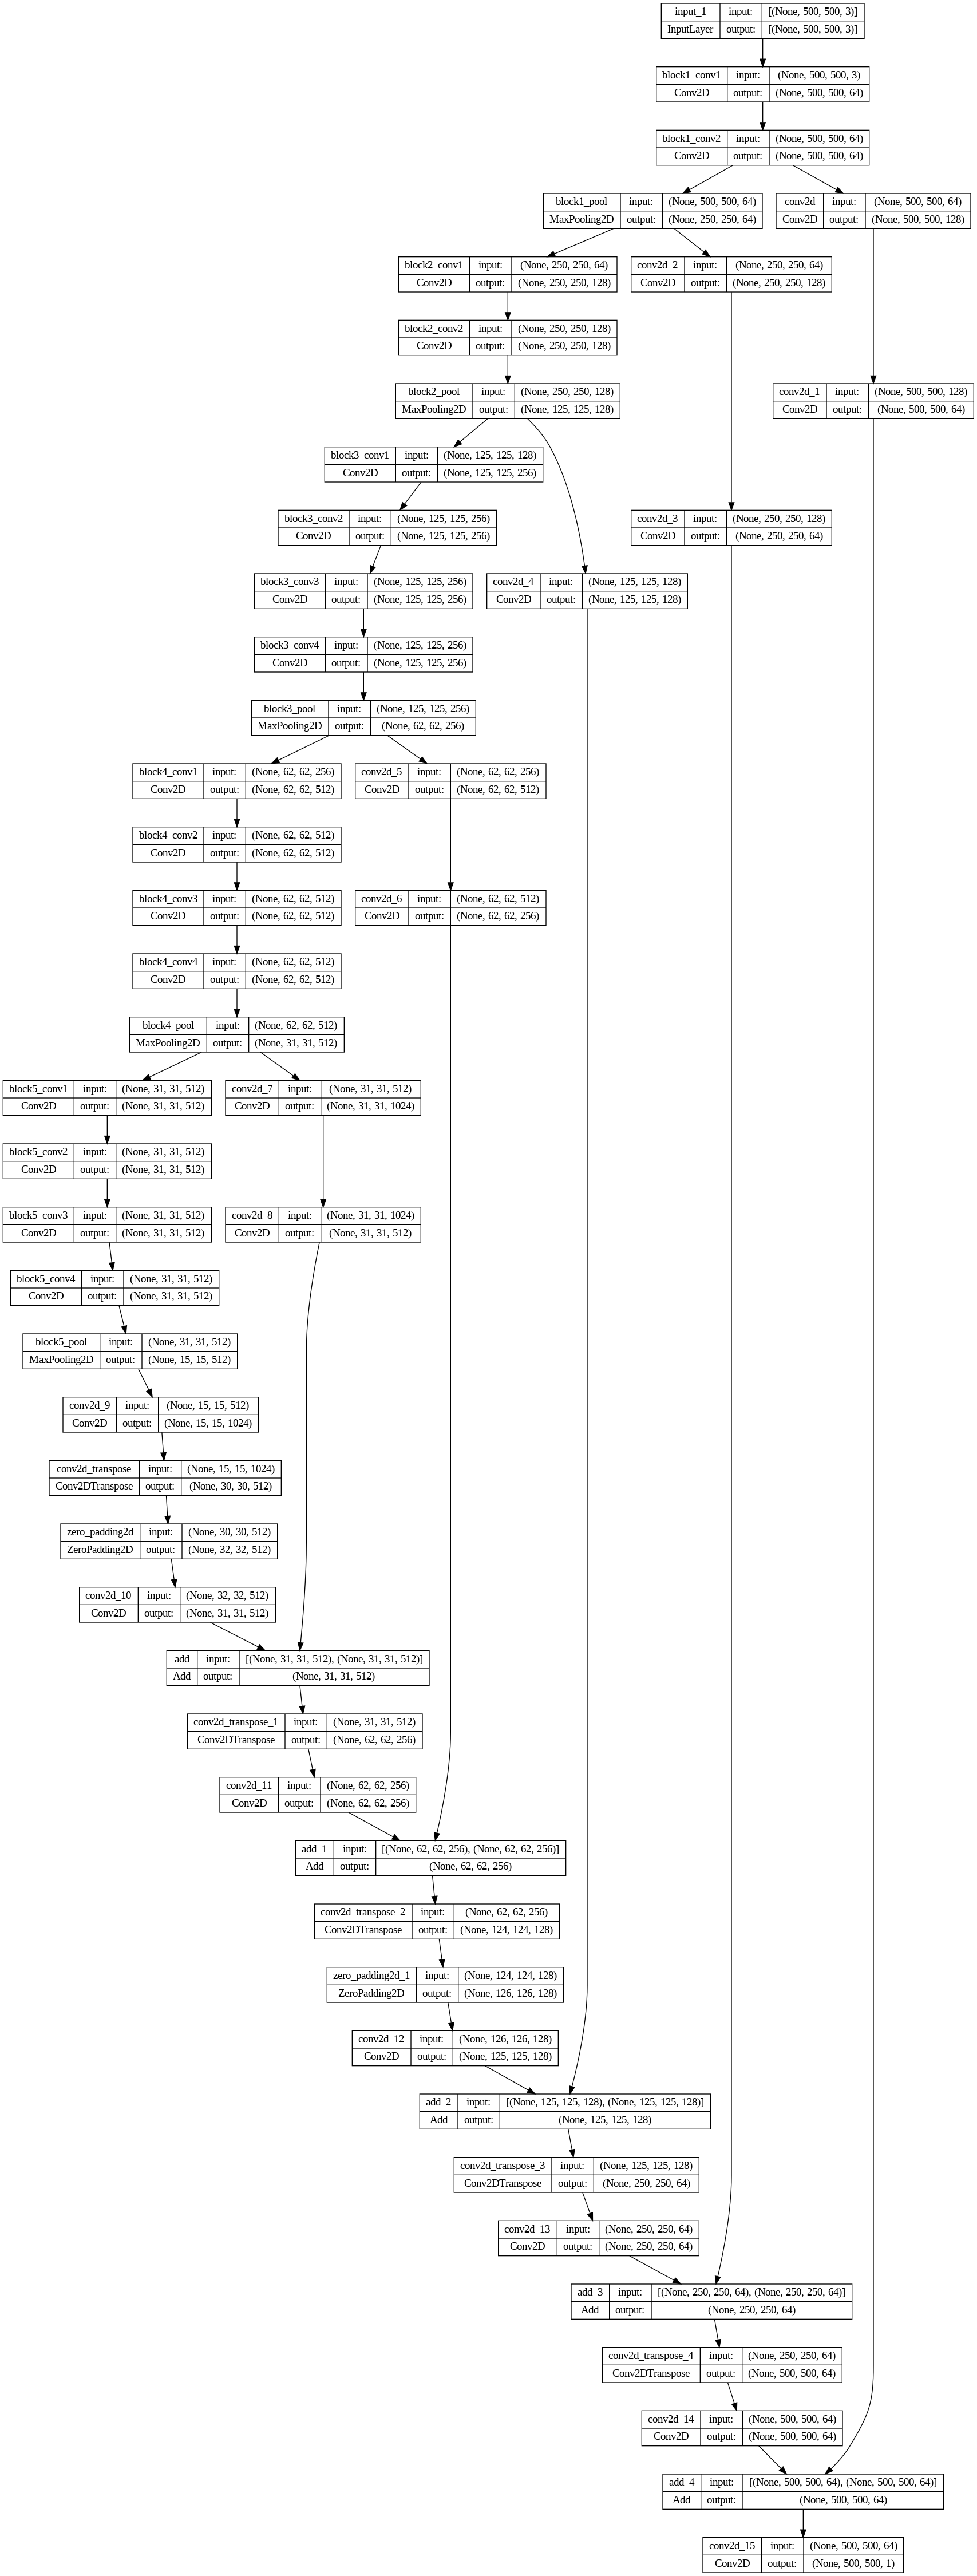

In [20]:
plot_model(model,show_shapes=True,show_layer_names=True,expand_nested=True)

In [21]:
train_path=r"Train"

image_datagen = ImageDataGenerator(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest',
                    rescale=1/255.)
mask_datagen = ImageDataGenerator(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest',
                    rescale=1/255.)
B_size=1
seed = 1
image_generator = image_datagen.flow_from_directory(
    train_path,
    class_mode=None,
    classes=['images'],
    color_mode='rgb',
    seed=seed,
    batch_size=B_size,
    target_size=(500,500))

mask_generator = mask_datagen.flow_from_directory(
    train_path,
    classes=['masks'],
    color_mode='grayscale',
    class_mode=None,
    seed=seed,
    batch_size=B_size,
    target_size=(500,500))
train_generator = zip(image_generator, mask_generator)

def train_generator_fn():

    for (img,mask) in train_generator:
        yield (img,mask)

Found 132 images belonging to 1 classes.
Found 132 images belonging to 1 classes.


In [22]:
val_path=r"Val"

image_datagen = ImageDataGenerator(rescale=1/255.)
mask_datagen = ImageDataGenerator(rescale=1/255.)
B_size=1
seed = 1
image_generator = image_datagen.flow_from_directory(
    val_path,
    class_mode=None,
    classes=['images'],
    color_mode='rgb',
    seed=seed,
    batch_size=B_size,
    target_size=(500,500))

mask_generator = mask_datagen.flow_from_directory(
    val_path,
    classes=['masks'],
    color_mode='grayscale',
    class_mode=None,
    seed=seed,
    batch_size=B_size,
    target_size=(500,500))
val_generator = zip(image_generator, mask_generator)

def val_generator_fn():

    for (img,mask) in val_generator:
      yield (img,mask)

Found 33 images belonging to 1 classes.
Found 33 images belonging to 1 classes.


Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 0.2453 - accuracy: 0.9279 - IOU: 0.4804 
Epoch 1: val_loss improved from inf to 0.22635, saving model to CheckPoint.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 538s 53s/step - loss: 0.2453 - accuracy: 0.9279 - IOU: 0.4804 - val_loss: 0.2264 - val_accuracy: 0.9319 - val_IOU: 0.4725 - lr: 1.0000e-04
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.2192 - accuracy: 0.9201 - IOU: 0.4769 
Epoch 2: val_loss did not improve from 0.22635
10/10 [==============================] - 504s 52s/step - loss: 0.2192 - accuracy: 0.9201 - IOU: 0.4769 - val_loss: 0.2336 - val_accuracy: 0.9269 - val_IOU: 0.4703 - lr: 1.0000e-04
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.1915 - accuracy: 0.9187 - IOU: 0.4765 
Epoch 3: val_loss improved from 0.22635 to 0.18319, saving model to CheckPoint.hdf5
10/10 [==============================] - 527s 53s/step - loss: 0.1915 - accuracy: 0.9187 - IOU: 0.4765 - val_loss: 0.1832 - val_accuracy: 0.9465 - val_IOU: 0.4784 - lr: 1.0000e-04
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 0.1312 - accuracy: 0.9382 - IOU: 0.4832 
Ep

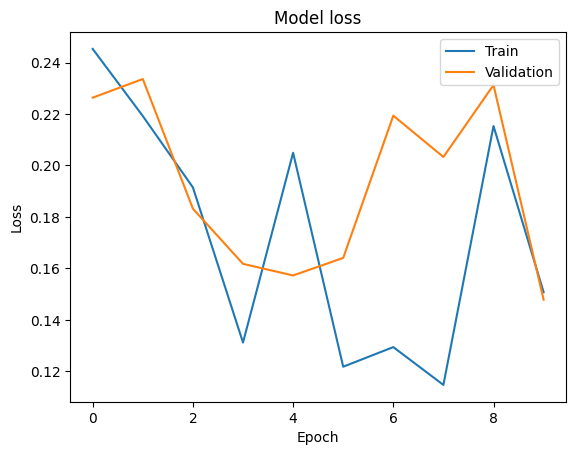

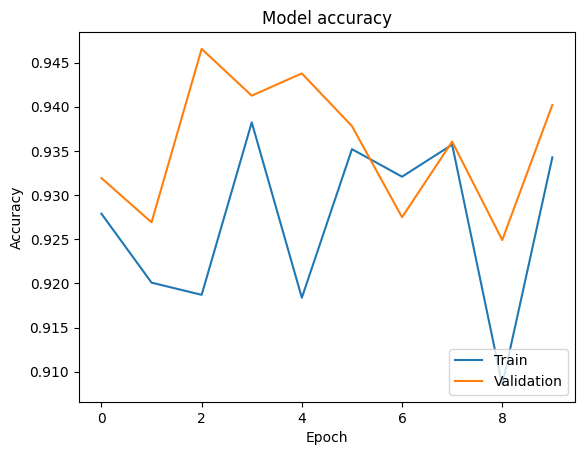

In [ ]:
model_checkpoint = ModelCheckpoint('CheckPoint.hdf5', monitor='val_loss',verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=4, min_lr=1e-8)
epochs=10
validation_steps=15
with tf.device('/cpu:0'):
    history = model.fit(train_generator_fn(),
                        validation_data=val_generator_fn(),
                        steps_per_epoch=10,
                        validation_steps=validation_steps,
                        epochs=10,
                        callbacks=[model_checkpoint, reduce_lr])

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# train, val acc
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [23]:
test=tiff.imread("/content/drive/MyDrive/testing.tif")
test_mask=tiff.imread("/content/drive/MyDrive/testing_groundtruth.tif")

In [24]:
if not os.path.isdir("Test/images"):
  os.makedirs("Test/images")
if not os.path.isdir("Test/masks"):
  os.makedirs("Test/masks")

In [25]:
for img in range(test.shape[0]):
    img_name = "image_{}.jpg".format(img)
    cv2.imwrite("Test/images/{}".format(img_name), test[img])

for img in range(test_mask.shape[0]):
    mask_name = "mask_{}_L.jpg".format(img)
    cv2.imwrite("Test/masks/{}".format(mask_name), test_mask[img])

In [26]:
test_path=r"Test"
test_image_generator = image_datagen.flow_from_directory(
    test_path,
    class_mode=None,
    classes=['images'],
    color_mode='rgb',
    seed=seed,
    batch_size=B_size,
    target_size=(500,500))

test_mask_generator = mask_datagen.flow_from_directory(
    test_path,
    classes=['masks'],
    class_mode=None,
    seed=seed,
    color_mode='grayscale',
    batch_size=B_size,
    target_size=(500,500))

test_generator = zip(test_image_generator, test_mask_generator)

def test_generator_fn():
    for (img,mask) in test_generator:
        yield (img,mask)

Found 165 images belonging to 1 classes.
Found 165 images belonging to 1 classes.


In [28]:
from skimage.io import imread
ground_truth_path = '/content/Test/images/image_100.jpg'
predicted_image_path = '/content/Test/masks/mask_100_L.jpg'

ground_truth = imread(ground_truth_path)
predicted_image = imread(predicted_image_path)

# Ensure the images are of the same shape
assert ground_truth.shape == predicted_image.shape

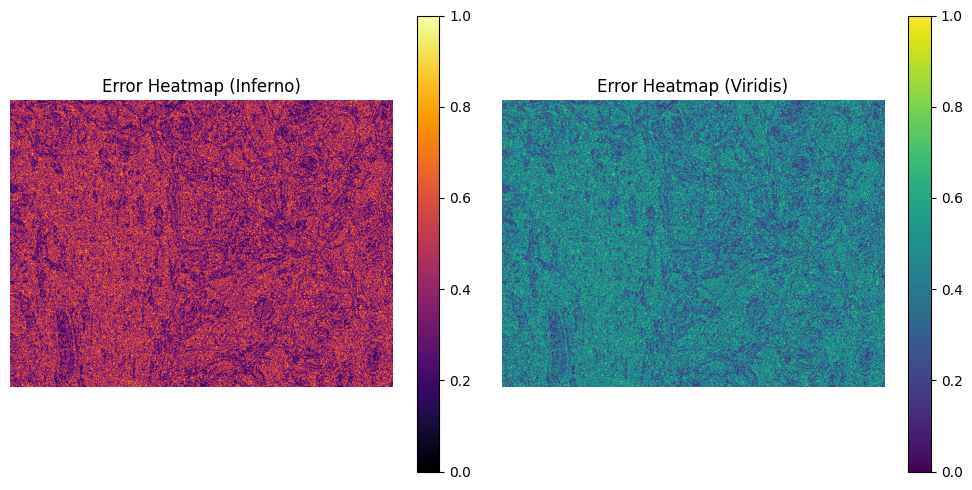

In [33]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Error Heatmap (Inferno)')
plt.imshow(normalized_error, cmap='inferno')
plt.colorbar()
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Error Heatmap (Viridis)')
plt.imshow(normalized_error, cmap='viridis')
plt.colorbar()
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
model.evaluate(test_generator_fn(),steps=30,batch_size=1)

 5/30 [====>.........................] - ETA: 3:09 - loss: 1.3815 - accuracy: 0.4737 - IOU: 0.2840

KeyboardInterrupt: 

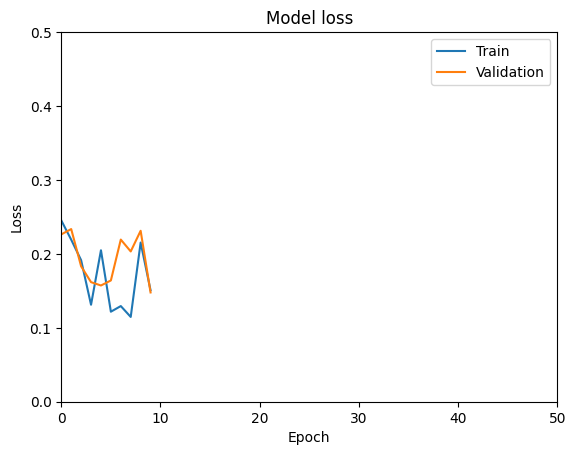

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.ylim([0, 0.5])
plt.xlabel('Epoch')
plt.xlim([0, 50])
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

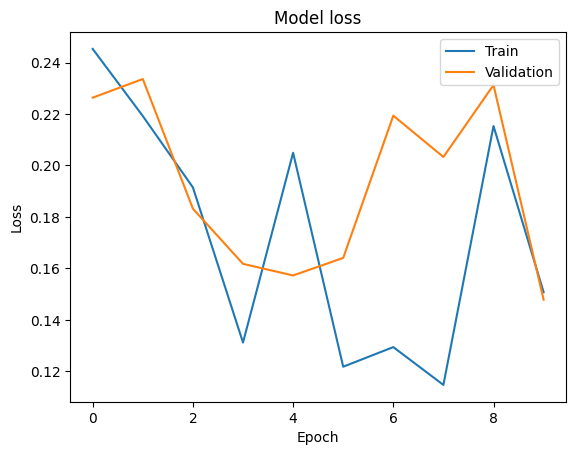

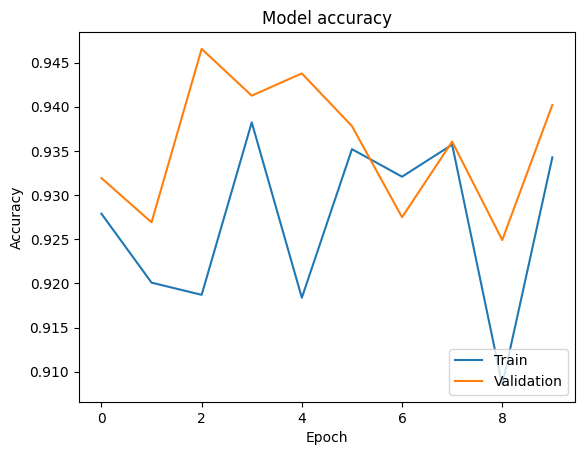

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# train, val accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

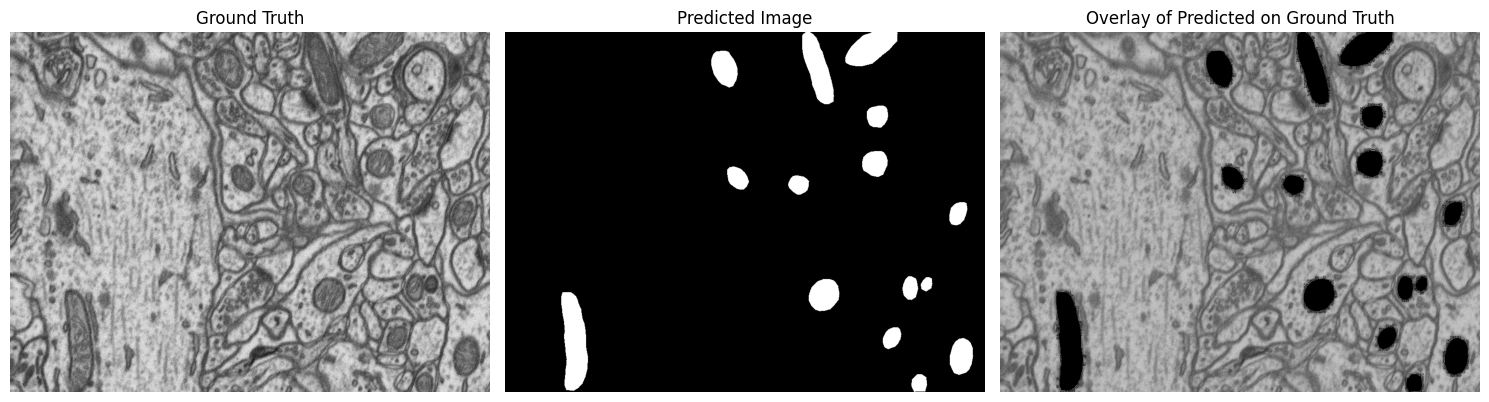

In [39]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread
from skimage.color import gray2rgb

# Load images
ground_truth_path = '/content/Test/images/image_100.jpg'
predicted_image_path = '/content/Test/masks/mask_100_L.jpg'
ground_truth = imread(ground_truth_path)
predicted_image = imread(predicted_image_path)

# Ensure the images are of the same shape
assert ground_truth.shape == predicted_image.shape
ground_truth_rgb = gray2rgb(ground_truth)
predicted_mask = predicted_image > 0

highlight_color = [1, 0, 0]  # Red color
highlighted_image = ground_truth_rgb.copy()
highlighted_image[predicted_mask] = highlight_color

# Update the visualization
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title('Ground Truth')
plt.imshow(ground_truth, cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.title('Predicted Image')
plt.imshow(predicted_image, cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.title('Overlay of Predicted on Ground Truth')
plt.imshow(highlighted_image)
plt.axis('off')
plt.tight_layout()
plt.show()
